# LVL2 Script

In [1]:
#import external libraries
import pandas as pd
import os
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt

#plotting
%matplotlib notebook

#import self-written libraries
import LVL1
import CleanWxData as wx

import settings
from settings import base_path, Glacier, Station

data_columns, general_data_columns, out_date_format, precip_columns, precip_gage_change, primary_temp_column, temp_columns, timezone, wind_col, wind_dir_columns = settings.get_settings(settings.Glacier, settings.Station)

In [2]:
#Data Import Tasks
#path to level 1 data
timezone='America/Anchorage' #choose from pytz.all_timezones

file_label='_15min_all'

pth=base_path + "Data/" +Glacier+ r"/AllYears/Wx/LVL1/" + Glacier.lower()+Station+file_label+"_LVL1.csv"

#time format and column
Local_time_column_name='local_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/"

In [3]:
#read in level1 CSV
dat=pd.read_csv(pth)
print(pth)

Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL1/wolverine990_15min_all_LVL1.csv


In [4]:
dat.head()

,local_time,UTC_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,TPGCumulative,StageCumulative,WindSpeed,WindDir,VecAvgWindDir,RelHum,WindGustSpeed
0,1997/08/28 20:00,1997/08/29 04:00,11.74,11.46,NaN,NaN,NaN,NaN,4.085,NaN,NaN,NaN,NaN
1,1997/08/28 20:15,1997/08/29 04:15,11.40,11.12,NaN,NaN,NaN,NaN,3.539,NaN,NaN,NaN,NaN
2,1997/08/28 20:30,1997/08/29 04:30,11.17,10.88,NaN,NaN,NaN,NaN,3.434,NaN,NaN,NaN,NaN
3,1997/08/28 20:45,1997/08/29 04:45,10.97,10.67,NaN,NaN,NaN,NaN,4.081,NaN,NaN,NaN,NaN
4,1997/08/28 21:00,1997/08/29 05:00,10.66,10.36,NaN,NaN,NaN,NaN,4.676,NaN,NaN,NaN,NaN


In [5]:
dat['local_time']=pd.to_datetime(dat[Local_time_column_name], format= date_format)
dat=dat.set_index('local_time') #set this local time as the index
dat.head(1)

,UTC_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,TPGCumulative,StageCumulative,WindSpeed,WindDir,VecAvgWindDir,RelHum,WindGustSpeed
local_time,,,,,,,,,,,,
1997-08-28 20:00:00,1997/08/29 04:00,11.74,11.46,NaN,NaN,NaN,NaN,4.085,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


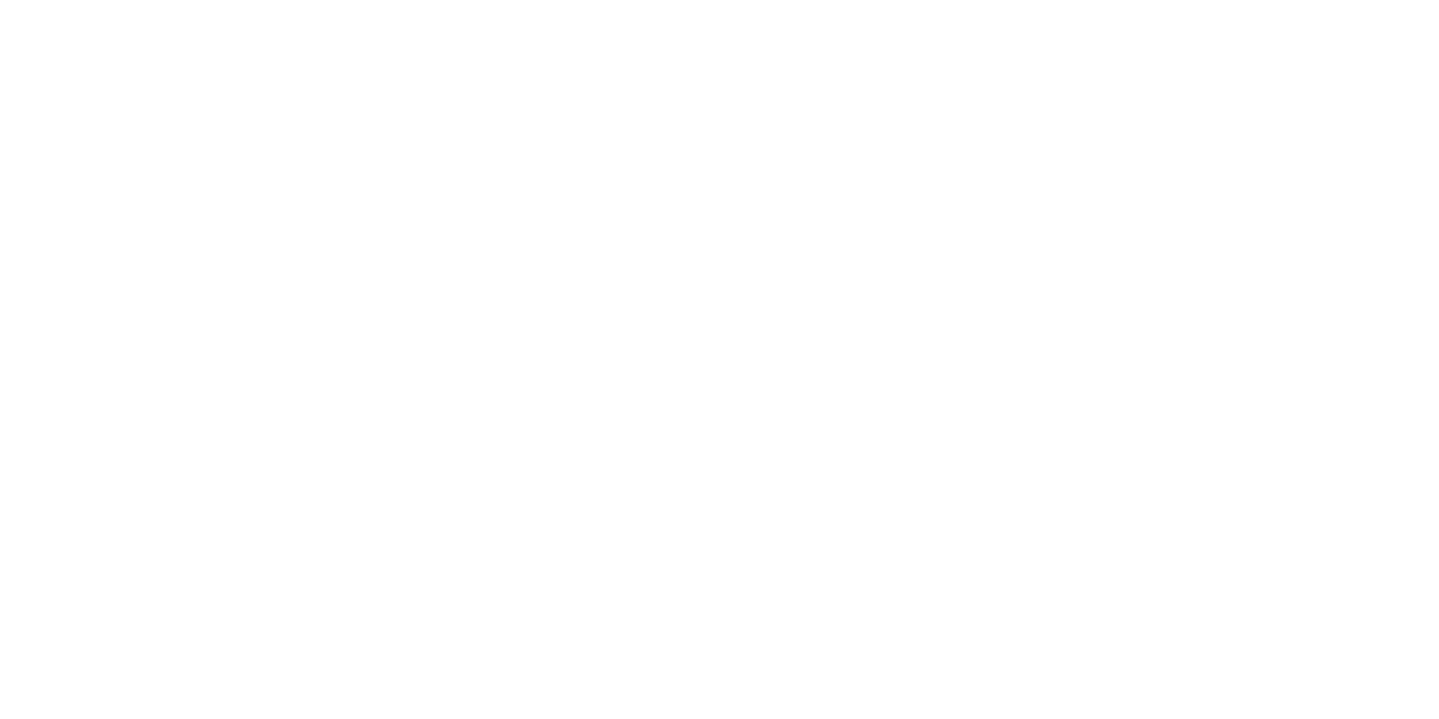

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\tools\plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


In [6]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
dat.plot(ax=ax, subplots=True, sharex=True) # ax=ax points df.plot to fig
for each in fig.axes: # You can still modify these axes!
    each.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data/'+ Glacier+r'\AllYears\Wx\LVL1/' +'LVL1' +Glacier +'WxData.jpg')

In [7]:
incremental_precip_columns=[] #create names for incremental precip columns
for precip_col in precip_columns:
    col_name=precip_col.split("Cumulative")[0]+"Incremental"
    incremental_precip_columns.append(col_name)
    dat[col_name]=dat[precip_col]-dat[precip_col].shift(1)
    if not np.isnan(dat[precip_col][0]):
        dat.ix[0, col_name]=0 #set first value to 0, not NAN IF the initial cumulative series was also not null

# Fill Gaps -temp
 #### * 15 min data

In [8]:
#dat[precip_columns].plot()

In [9]:
best_temp_name='site_temp'

In [10]:
#Store original primary sensor data for later comparrison
dat['orig_T1']=dat[primary_temp_column].copy()
dat[best_temp_name]=dat[primary_temp_column].copy()

#Identify if primary sensor is passive or aspirated
primary_temp_aspirated='aspirated' in primary_temp_column.lower()

In [11]:
#List alternate temp columns
secondary_temp_columns=list(set(temp_columns)-set([primary_temp_column]))
passive_temp_columns=[s for s in temp_columns if "passive" in s]

In [12]:
#Store locations of long NAN gaps in primary sensor record to be filled
primary_temp_null_indx=dat[primary_temp_column].isnull()

<IPython.core.display.Javascript object>


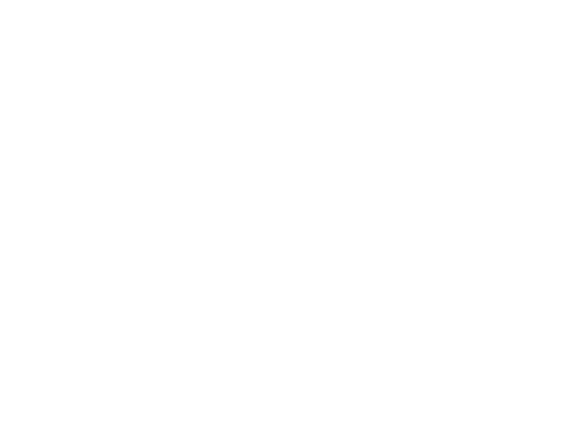

In [13]:
dat[temp_columns].plot()

In [14]:
#Remove bad sensor data, where a value is >4 degrees different from the 2-hour median temp. 
for temp_col in [temp_columns]:
    dat[temp_col]=LVL1.hampel(dat[temp_col], k=7) #remove outliers with hampel filter
    dat[temp_col]=LVL1.basic_median_outlier_strip(dat[temp_col], k=8, threshold=4, min_n_for_val=3) #remove remaining outliers; spikes where val exceeds 2-hr rolling median by 4C    

In [15]:
#Subset data to alternate temperature columns (for gap filling)
secondary_temp_dat=dat[secondary_temp_columns].copy()
#Check if any secondary temp sensors exist
secondary_temps_exist= not secondary_temp_dat.dropna(how='all').empty

In [16]:
if secondary_temps_exist:    
    #Calculate the mean of the secondary temp values
    secondary_temp_dat['temp_mean']=secondary_temp_dat[secondary_temp_columns].mean(axis=1)
    #Calculate standard dev. of secondary temp values
    secondary_temp_dat['temp_sd']=secondary_temp_dat[secondary_temp_columns].std(axis=1)
    #Calculate temperature difference between avg. of other temperatures
    secondary_temp_dat['temp_diff']=abs(dat[primary_temp_column]-secondary_temp_dat.mean(axis=1))
    #Calculate the median of secondary temp values
    secondary_temp_dat['temp_median']=secondary_temp_dat[secondary_temp_columns].median(axis=1)
    #Calculate mean of passive temperature sensors (if a sensor is missing, mean will be NAN)
    secondary_temp_dat['passive_average']=dat[passive_temp_columns].mean(axis=1, skipna=False)
    #Calculate difference of 2 passive sensors from one another
    if len(passive_temp_columns)>1:
        secondary_temp_dat['passive_difference_between_sensors']=abs(dat[passive_temp_columns[0]]-dat[passive_temp_columns[1]])
    else:
        secondary_temp_dat['passive_difference_between_sensors']=pd.np.nan
        

    #ID times when more than 1 passive temperature sensor is available
    more_than_one_passive_temp_avail_idx=dat[passive_temp_columns].notnull().sum(axis=1)>1

    #ID variation among other sensors
    low_variation_secondary_sensors_idx=secondary_temp_dat[secondary_temp_columns].std(axis=1)<1.5

    #Fill remaining gaps (>3 length) in primary timeseries with average of all other sensors, when > 1 available
    dat.loc[dat[primary_temp_column].isnull() & low_variation_secondary_sensors_idx, best_temp_name]=secondary_temp_dat.temp_median[dat[primary_temp_column].isnull()&low_variation_secondary_sensors_idx]

    if primary_temp_aspirated:
        #Find places where aspirated is hotter than passive sensor mean
        asp_more_than_2deg_diff_from_passivemean_idx=(dat[primary_temp_column]- secondary_temp_dat.passive_average)>2 #difference between asp and passive mean > 2 deg
        #pass_colder_than_asp_over_halfdeg_idx=(dat[primary_temp_column]- secondary_temp_dat.passive_average)>0.5 #Redundant with above
    else:
        asp_more_than_2deg_diff_from_passivemean_idx=pd.Series(False, index=dat.index)

    
    #In places where the passive AGREE with eachother, but DISAGREE with the aspirated mean, set main aspirated T to mean of passive.
    passive_sensors_agree_with_eachother_halfdeg_idx= secondary_temp_dat.passive_difference_between_sensors<0.5 #passive sensors agree with eachother (<0.5 deg diff)

    #Replace data in Aspirated with Passive mean where asp disagrees with passive, and more than 1 secondary temp sensor available
    dat.loc[asp_more_than_2deg_diff_from_passivemean_idx &
            passive_sensors_agree_with_eachother_halfdeg_idx &
            more_than_one_passive_temp_avail_idx, 
            best_temp_name]=secondary_temp_dat.loc[asp_more_than_2deg_diff_from_passivemean_idx &
                                                        passive_sensors_agree_with_eachother_halfdeg_idx &
                                                        more_than_one_passive_temp_avail_idx,'passive_average']

    #Fill remaining NANs in primary temperature time series with median of all other sensors, where variation is low
    dat.loc[dat[best_temp_name].isnull() & 
            low_variation_secondary_sensors_idx,
            best_temp_name]=secondary_temp_dat.temp_median[dat[best_temp_name].isnull() &
                                                               low_variation_secondary_sensors_idx]

    #Temporarily fill remaining NANs in primary timeseries, in order to do outlier stripping
    Nan_locations_to_restore=dat[best_temp_name].isnull()
    dat.loc[dat[best_temp_name].isnull(), best_temp_name]=secondary_temp_dat.temp_median[dat[best_temp_name].isnull()]
else:
    print('no secondary temperatures; keeping primary as-is')

In [17]:
if secondary_temps_exist:    
    #Restore NANs back into timeseries, where we are unsure which secondary sensors are best to use
    dat.loc[Nan_locations_to_restore, best_temp_name]=np.nan

    dat['full_count'] = dat[secondary_temp_columns].apply(lambda x: x.count(), axis=1) #count how many temperature obs we have for a given time

    #At times where secondary temperature sensors do not agree, but more than one is present, expert judgment should be used.
    #To implement this, identify the period during which a secondary sensor is malfunctioning, and enter into "error" step in LVL1 script
    if len(dat[dat[best_temp_name].isnull() &dat.full_count>1])>0:
        print("secondary sensors do not agree; manually determine which should be used here, and add bad to list in LVL1 processing")

    #If primary record NANs still remain, substitute median of alternate temperatures
    if len(dat[dat[best_temp_name].isnull() &dat.full_count>1])==0:
        dat.loc[dat[best_temp_name].isnull(), best_temp_name]=secondary_temp_dat.temp_median[dat[best_temp_name].isnull()]
else:
    print('no secondary temperatures; keeping primary as-is')

In [18]:
#Smooth 15-minute 'best temp' time series -Remove bad sensor data, where a value is >4 degrees different from the 2-hour median temp. 
for temp_col in [best_temp_name]:
    dat[temp_col]=LVL1.hampel(dat[temp_col], k=7) #remove outliers with hampel filter
    dat[temp_col]=LVL1.basic_median_outlier_strip(dat[temp_col], k=8, threshold=4, min_n_for_val=3) #remove remaining outliers; spikes where val exceeds 2-hr rolling median by 4C    

In [19]:
#dat[temp_columns+ ['orig_T1']]['2010'].plot() #this shows the 15 min still has holes; interpolation is whats going down

In [20]:
#Calculate vector-average wind direction if not already present
if 'WindSpeed' and 'WindDir' in dat.columns:
    if 'VecAvgWindDir' in dat.columns:
        dat.loc[dat.VecAvgWindDir.isnull(), 'VecAvgWindDir']=LVL1.vector_average_wind_direction_individual_timestep(WS=dat.WindSpeed[dat.VecAvgWindDir.isnull()], WD=dat.WindDir[dat.VecAvgWindDir.isnull()])
    else:
        dat['VecAvgWindDir']=LVL1.vector_average_wind_direction_individual_timestep(WS=dat.WindSpeed, WD=dat.WindDir)
        wind_dir_columns=wind_dir_columns + ['VecAvgWindDir']

## Save final 15 minute data

In [22]:
temp_columns=[best_temp_name]+temp_columns

In [23]:
out_columns=temp_columns +incremental_precip_columns+general_data_columns +wind_dir_columns #columns to include in output
save_name=Glacier.lower()+ Station + "_15min_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name)

In [24]:
#List columns being omitted from saved data
print ('missing columns :' + str(set(dat.columns) - set(out_columns)))
print(dat.columns)

missing columns :{'UTC_time', 'TPGCumulative', 'StageCumulative', 'full_count', 'orig_T1'}
Index(['UTC_time', 'Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2',
       'TPGCumulative', 'StageCumulative', 'WindSpeed', 'WindDir',
       'VecAvgWindDir', 'RelHum', 'WindGustSpeed', 'TPGIncremental',
       'StageIncremental', 'orig_T1', 'site_temp', 'full_count'],
      dtype='object')


In [25]:
dat.columns

Index(['UTC_time', 'Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2',
       'TPGCumulative', 'StageCumulative', 'WindSpeed', 'WindDir',
       'VecAvgWindDir', 'RelHum', 'WindGustSpeed', 'TPGIncremental',
       'StageIncremental', 'orig_T1', 'site_temp', 'full_count'],
      dtype='object')

In [26]:
dat[out_columns].to_csv(save_pth, float_format='%g', date_format=date_format) #save data

# Hourly Data

In [27]:
#Temperature - fill gaps in primary temperature under 1 hour
dat_before_fill=dat.copy()
for temp_col in temp_columns:
    print(temp_col)
    dat.loc[:,temp_col]=dat[temp_col].interpolate(method='linear', limit=3)

site_temp
Tpassive1
Tpassive2
TAspirated1
TAspirated2


In [28]:
hourly_dat=pd.DataFrame()

In [29]:
#Create Hourly Data -
#Temperature
hourly_dat=pd.DataFrame()
for temp_col in temp_columns:
    #Create WMO Mean Temp
    hourly_dat[temp_col+"_min"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='min')
    hourly_dat[temp_col+ "_max"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='max')
    hourly_dat[temp_col+"_WMO"]=hourly_dat[[temp_col+"_min", temp_col+'_max']].mean(axis=1)
    #Create USGS Mean Temp
    hourly_dat[temp_col+"_USGS"]=wx.aggregate_time_with_threshold(dat[temp_col], 'H', steps_in_period=4, func='mean')
    
#Precipitation
for incremental_precip_col in incremental_precip_columns:
    hourly_dat[incremental_precip_col]=dat[incremental_precip_col].resample('H', label='left').sum() #all precip recieved during his hour
    
#Other Data Types (that can be aggregated with a simple mean)
for general_data_col in general_data_columns:
    hourly_dat[general_data_col]=wx.aggregate_time_with_threshold(dat[general_data_col], 'H', steps_in_period=4, func='mean')

if len(wind_dir_columns)>0:
    #Wind Direction - this process is for data that is logged as vector-averaged 
      # for data that is not, use LVL1.vector_average_wind_direction()
    for wd_col in wind_dir_columns:
        #Convert to raidans
        dat['wind_dir_cos']=np.cos(dat[wd_col]*(np.pi/180))
        dat['wind_dir_sin']=np.sin(dat[wd_col]*(np.pi/180))

        #Calculate mean of x and y directions in radian space
        hourly_dat['wind_dir_cos']=wx.aggregate_time_with_threshold(dat.wind_dir_cos, 'H', steps_in_period=4, func='mean')
        hourly_dat['wind_dir_sin']=wx.aggregate_time_with_threshold(dat.wind_dir_sin, 'H', steps_in_period=4, func='mean')
        #Convert back to 0-360 coordinates
        hourly_dat[wd_col]=(np.arctan2(hourly_dat.wind_dir_sin, hourly_dat.wind_dir_cos) * 180/np.pi)
        hourly_dat.loc[hourly_dat[wd_col]<0, wd_col]+=360 #add 360 where hourly dat less than 0

In [30]:
if 'Discharge' in dat.columns:
    hourly_dat['Discharge']=wx.aggregate_time_with_threshold(dat['Discharge'], 'H', steps_in_period=4, func='sum')

In [31]:
# ax=dat[temp_columns+ ['orig_T1']]['2010'].plot(color=['blue', 'green']) #this shows the 15 min still has holes; interpolation is whats going down
# hourly_dat['Tpassive1_USGS']['2010'].plot(ax=ax, color='red')

<IPython.core.display.Javascript object>


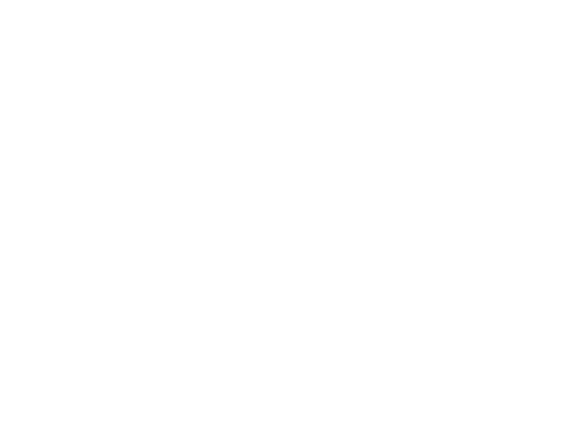

In [32]:
usgs_temp_cols=hourly_dat.columns[hourly_dat.columns.str.contains("USGS")]
#plt.figure()
hourly_dat[usgs_temp_cols].plot()

In [33]:
#Define names of output columns
out_temp_columns = [s for s in hourly_dat.columns if best_temp_name in s]
temp_mean_columns=[t for t in hourly_dat.columns if "USGS" in t]

out_columns=out_temp_columns+incremental_precip_columns+general_data_columns+ wind_dir_columns +temp_mean_columns #columns to include in output
out_columns=pd.Series(out_columns).drop_duplicates().tolist() #drop duplicates

#### Save Data

In [34]:
if Glacier+Station=='Wolverine370':
    out_columns=out_temp_columns+incremental_precip_columns+general_data_columns
save_name=Glacier.lower()+ Station + "_hourly_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name)

hourly_dat[out_columns][:-1].to_csv(save_pth, float_format='%g', date_format=date_format) #write selected columns; omit last row (unlikely to be complete, with download)
print(save_pth)

Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/wolverine990_hourly_LVL2.csv


In [35]:
#Columns not being written to file
set(hourly_dat.columns) - set(out_columns)

{'TAspirated1_WMO',
 'TAspirated1_max',
 'TAspirated1_min',
 'TAspirated2_WMO',
 'TAspirated2_max',
 'TAspirated2_min',
 'Tpassive1_WMO',
 'Tpassive1_max',
 'Tpassive1_min',
 'Tpassive2_WMO',
 'Tpassive2_max',
 'Tpassive2_min',
 'wind_dir_cos',
 'wind_dir_sin'}

# Daily Data

In [36]:
#Temperature - fill gaps under 3 hours before aggregation
dat=dat_before_fill.copy() #reset 'dat' to be un-interpolated data
for temp_col in temp_columns:
    dat.loc[:,temp_col]=dat[temp_col].interpolate(method='linear', limit=12) #<= 3hrs;  at a 15 min interval, 3 hrs is 12 measurements

In [37]:
daily_dat=pd.DataFrame() #create empty dataframe
daily_quality_df=pd.DataFrame()

#Temperature
for temp_col in temp_columns:
    #Create WMO Mean Temp
    daily_dat[temp_col+"_min"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='min')
    daily_dat[temp_col+ "_max"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='max')
    daily_dat[temp_col+"_WMO"]=daily_dat[[temp_col+"_min", temp_col+'_max']].mean(axis=1)
    #Create USGS Mean Temp
    daily_dat[temp_col+"_USGS"]=wx.aggregate_time_with_threshold(dat[temp_col], 'D', steps_in_period=96, func='mean')   
    
#Precipitation
for incremental_precip_col in incremental_precip_columns:
    daily_dat[incremental_precip_col]=dat[incremental_precip_col].resample('D', label='left').sum() #all precip recieved during this day; label on right
    
#Other Data Types (that can be aggregated with a simple mean)
for general_data_col in general_data_columns:
    daily_dat[general_data_col]=wx.aggregate_time_with_threshold(dat[general_data_col], 'D', steps_in_period=96, func='mean') 

    
if len(wind_dir_columns)>0:    
    #Wind Direction - this process is for data that is logged as vector-averaged 
      # for data that is not, use LVL2.vector_average_wind_direction to create
    for wd_col in wind_dir_columns:
        #Convert to raidans
        dat['wind_dir_cos']=np.cos(dat[wd_col]*(np.pi/180))
        dat['wind_dir_sin']=np.sin(dat[wd_col]*(np.pi/180))

        #Calculate mean of x and y directions in radian space
        daily_dat['wind_dir_cos']=wx.aggregate_time_with_threshold(dat.wind_dir_cos, 'D', steps_in_period=96, func='mean')
        daily_dat['wind_dir_sin']=wx.aggregate_time_with_threshold(dat.wind_dir_sin, 'D', steps_in_period=96, func='mean')

        #Convert back to 0-360 coordinates
        daily_dat[wd_col]=(np.arctan2(daily_dat.wind_dir_sin, daily_dat.wind_dir_cos) * 180/np.pi)
        daily_dat.loc[daily_dat[wd_col]<0, wd_col]+=360

In [38]:
if 'Discharge' in dat.columns:
    daily_dat['Discharge']=wx.aggregate_time_with_threshold(dat['Discharge'], 'D', steps_in_period=96, func='sum', threshold=0.6)

#### Save Data

In [39]:
save_name=Glacier.lower()+ Station + "_daily_"+"LVL2.csv" #filename
save_pth=os.path.join(save_dir, save_name) #location to save file

In [40]:
#Set number of decimals to save for each type of data. Split into 3 separate loops for easy option of changing for each type.
for col in out_temp_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round temperature to 1 decimal places; store as string 

for col in incremental_precip_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round precip to 1 decimal place

for col in general_data_columns:
    daily_dat[col]=["%.1f" %x for x in daily_dat[col]] #round general data cols to 1 decimal place

if len(wind_dir_columns)>0:
    for col in wind_dir_columns:
        daily_dat[col]=["%.0f" %x for x in daily_dat[col]] #wind direction; no decimal

In [41]:
save_dat=daily_dat[out_columns][:-1] #remove last row; day is not complete upon download
save_dat=save_dat[1:]#remove first day; likely not complete

In [42]:
#Rename columns to standard
#Generic Temperature Label
#final_names=[x.replace(primary_temp_column, 'Temp') for x in out_columns]
#Change precip label from Incremental to Precip (preserve type label)
final_names=[x.replace("Incremental", "_Precip") for x in out_columns]
save_dat.columns=final_names
save_dat.index.name='Date'

In [43]:
save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

In [44]:
save_pth

'Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/wolverine990_daily_LVL2.csv'

<IPython.core.display.Javascript object>


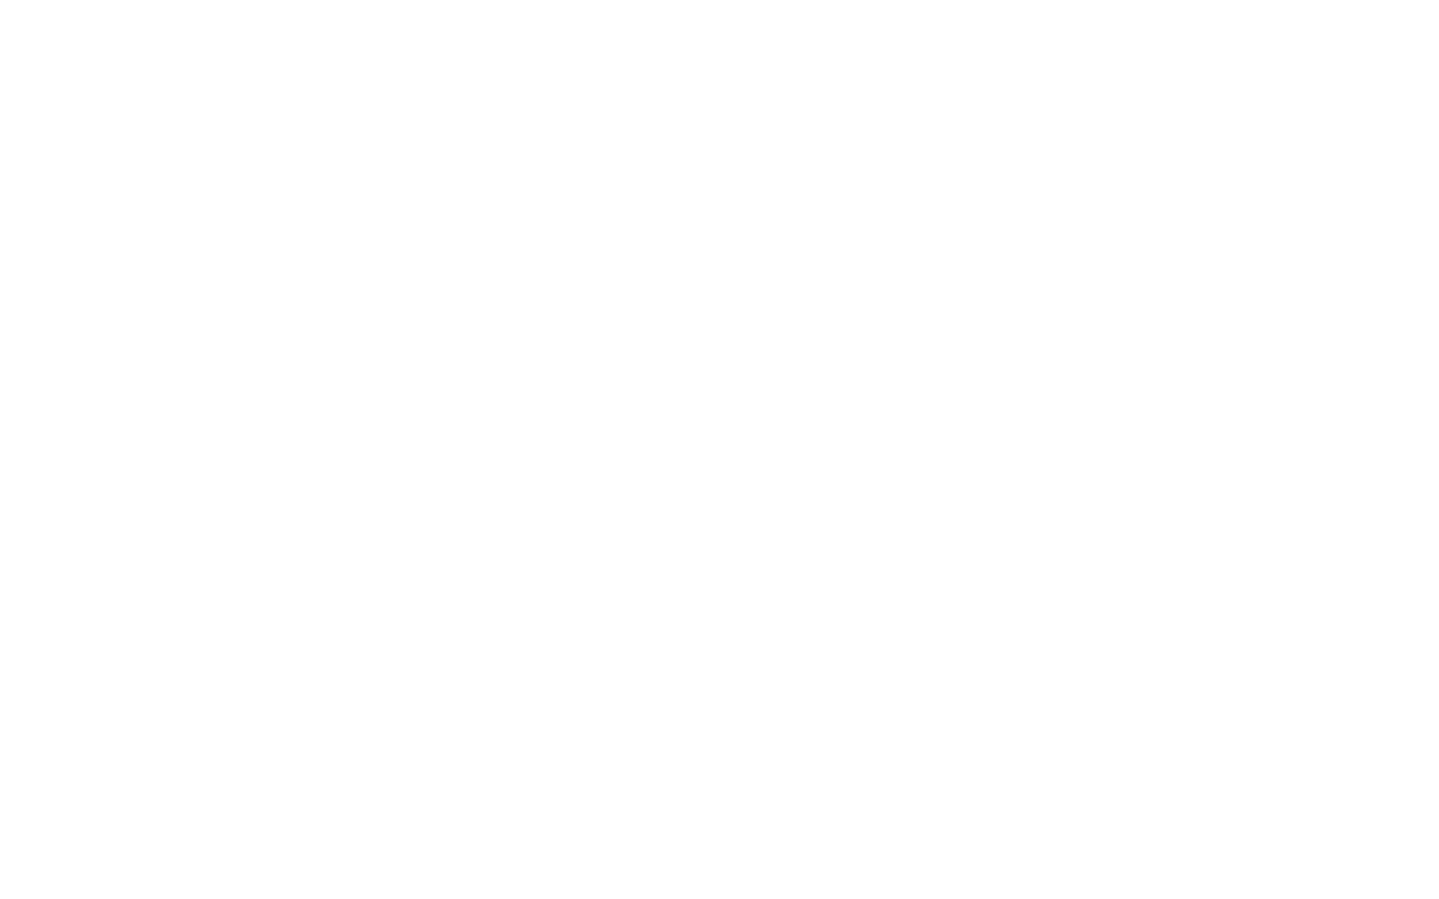

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\tools\plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


In [45]:
#Plot all the data
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
hourly_dat[out_columns].plot(ax=ax, subplots=True, layout=(len(out_columns),1), sharex=True) # ax=ax points df.plot to fig
for each in fig.axes: # You can still modify these axes!
    each.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data/' + Glacier+r'\AllYears\Wx\LVL2/LVL2S' + Glacier +'WxData.jpg')

In [46]:
daily_dat.site_temp_USGS[-1]

'nan'

In [47]:
# #Windrose plot
from windrose import WindroseAxes
import matplotlib.pyplot as plt
%matplotlib notebook

def new_axes():
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    plt.setp(l.get_texts(), fontsize=8)

#A stacked histogram with normed (displayed in percent) results :
hourly_dat=hourly_dat
ax = new_axes()
ax.bar(hourly_dat.VecAvgWindDir, hourly_dat.WindSpeed, normed=True, opening=0.8, edgecolor='white')
set_legend(ax)

<IPython.core.display.Javascript object>

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [48]:
dat.Tpassive1.plot()

TypeError: legend() got multiple values for argument 'loc'

In [ ]:
dat.Tpassive1.first_valid_index()

In [ ]:
pth

In [ ]:
secondary_temp_dat.tail(2)

In [ ]:
dat.TPGCumulative.plot()

In [ ]:
plt.figure()
dat.RelHum.plot()

In [ ]:
dat